In [1]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_name('Times New Roman')
plt.rcParams.update({'font.family':'serif'}) 

from utils import cap_bank_vals,vdict
from parse_scans import parse_scans

## Phase Scans

- [X] Plot width of phase scans as a function of TID and PLL value.
- [ ] Plot width of phase scans as a function of TID and eRx.
- [X] Plot phase scan (either eTx or eRx) as a function of TID/steps, for a given channel.
- [ ] Figure out TID to phase index conversion.
- [ ] Plot phase scan (either eTx or eRx), for all channels, for a given TID and CapSel.
- [ ] Plot the phase scan, for the PLL setting that was actually used.
  - [ ] Plot the phase value used vs phase value from trackMode=1.
  - [ ] Plot the number of prbs errors +/- 1 or 2 settings around the phase value "used".
- [ ] Infer best PLL setting and compare to what was actually used.
  - [ ] Best PLL setting from rule of 1/3.
  - [ ] Best PLL setting from widest input eye.
  - [ ] Best PLL setting from widest output eye.

In [2]:
board = '10'
df_scans = parse_scans(board,'2022-09-26 12')
df_scans.columns

Index(['timestamp', 'TID', 'capBank_val', 'eRxScan_1_20', 'eRxBest_1_20',
       'eRxMaxWidth_1_20', 'eRx2ndMaxWidth_1_20', 'eTxScan_1_20',
       'eTxBest_1_20', 'eTxMaxWidth_1_20', 'eTx2ndMaxWidth_1_20',
       'eRxScan_1_08', 'eRxBest_1_08', 'eRxMaxWidth_1_08',
       'eRx2ndMaxWidth_1_08', 'eTxScan_1_08', 'eTxBest_1_08',
       'eTxMaxWidth_1_08', 'eTx2ndMaxWidth_1_08', 'eRxScan_1_32',
       'eRxBest_1_32', 'eRxMaxWidth_1_32', 'eRx2ndMaxWidth_1_32',
       'eTxScan_1_32', 'eTxBest_1_32', 'eTxMaxWidth_1_32',
       'eTx2ndMaxWidth_1_32'],
      dtype='object')

In [3]:
df_scans.eTxScan_1_32

time
2022-09-26 12:02:57    [[999, 999, 999, 999, 999, 999, 999, 999, 999,...
2022-09-26 12:29:35    [[999, 999, 999, 999, 999, 999, 999, 999, 999,...
2022-09-26 12:57:55    [[999, 999, 999, 999, 999, 999, 999, 999, 999,...
2022-09-26 13:25:37    [[999, 999, 999, 999, 999, 999, 999, 999, 999,...
2022-09-26 13:52:47    [[999, 999, 999, 999, 999, 999, 999, 999, 999,...
                                             ...                        
2022-09-28 18:17:51    [[999, 999, 999, 999, 999, 999, 999, 999, 999,...
2022-09-28 18:51:19    [[999, 999, 999, 999, 999, 999, 999, 999, 999,...
2022-09-28 19:23:31    [[999, 999, 999, 999, 999, 999, 999, 999, 999,...
2022-09-28 19:55:39    [[999, 999, 999, 999, 999, 999, 999, 999, 999,...
2022-09-28 20:27:36    [[999, 999, 999, 999, 999, 999, 999, 999, 999,...
Name: eTxScan_1_32, Length: 3161, dtype: object

Plot width of phase scans as a function of TID

In [4]:
def plot_width_tid(scan,voltage,aspect=2,maxwidth='MaxWidth'):
    tid = np.array(df_scans.loc[df_scans.capBank_val == 31][f'TID'].values)
    width = []
    for val in cap_bank_vals:
        width.append(np.array(list(df_scans.loc[df_scans.capBank_val == val][f'{scan}{maxwidth}_{voltage}'].values)).mean(axis=1))
    width = np.array(width)

    fig,ax=plt.subplots(figsize=(12,9))
    cmap = mpl.colormaps['viridis']
    bounds=[0,1,2,3,4]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    # attempt to show TID instead of phase scan index
    #im = ax.imshow(width,cmap=cmap,norm=norm,extent=(0,tid[-1],len(cap_bank_vals),0))
    
    im = ax.imshow(width,cmap=cmap,norm=norm)
    
    fig.subplots_adjust(right=0.85)
    fig.colorbar(im,fraction=0.019, pad=0.04)
    ax.set_aspect(aspect)
    #ax.scatter(tid,width.argmax(axis=0),marker='x',color='w',label='PLL CapBank index with maximum width')
    ax.scatter(np.arange(width.shape[1]),width.argmax(axis=0),marker='x',color='w',label='PLL CapBank index with maximum width')
    #ax.set_xticks([tid[20],tid[40],tid[60],tid[80],tid[100]])
    ax.legend(labelcolor='w')
    ax.set_title(f'{maxwidth} of eRx good phases at {vdict[voltage]} V')
    ax.set_ylabel('PLL CapBank')
    ax.set_xlabel('Phase Scan Index')
    #ax.set_xlabel('TID [Mrad]')
    fig.tight_layout()

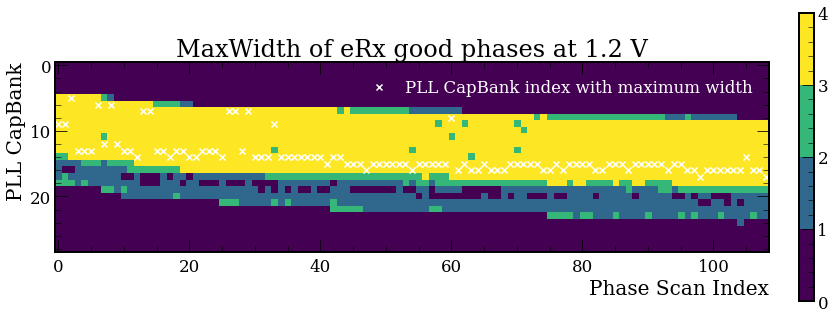

In [5]:
plot_width_tid('eRx','1_20',aspect=1,maxwidth='MaxWidth')

Plot Delay Scans as a function of TID for a given eRx/eTx

In [6]:
def plot_phase_scans_tid(scan,voltage,channel,aspect=2,pll_values = [25,26,27,28,29,30,31,56,57,58,59,60,61,62,63]):
    cmap = mpl.colormaps['bwr']
    if scan=='eRx': 
        #bounds=[0,50,100,255]
        bounds = np.arange(255)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        
    fig,ax=plt.subplots(figsize=(12,5*len(pll_values)),ncols=1,nrows=len(pll_values))
    for i,val in enumerate(pll_values):
        try:
            ax_i = ax[i]
        except:
            ax_i = ax
        
        x=np.array(list(df_scans.loc[df_scans.capBank_val == val][f'{scan}Scan_{voltage}'].values))
        #print(x)
        
        if scan=='eRx':
            im=ax_i.imshow(x[:,:,channel].T,cmap=cmap,norm=norm)
        else:
            im=ax_i.imshow(x[:,:,channel].T,cmap=cmap)
        # the following was an attempt to modify the axis to TID..
        #im=ax[i].imshow(x[:,:,channel].T,cmap=cmap,norm=norm,aspect=1.5,extent=(0,tid[-1],x[:,:,channel].shape[1],0))
        fig.colorbar(im,fraction=0.013, pad=0.04,ax=ax_i)
        ax_i.set_aspect(aspect)
        ax_i.set_xlabel('Phase Scan Index')
        #ax_i.set_xlabel('TID')
        ax_i.set_ylabel('Phase Delay Setting')
        ax_i.set_title(f'CapBank Select {val},{scan} {channel}, V={vdict[voltage]} V')
    fig.tight_layout()

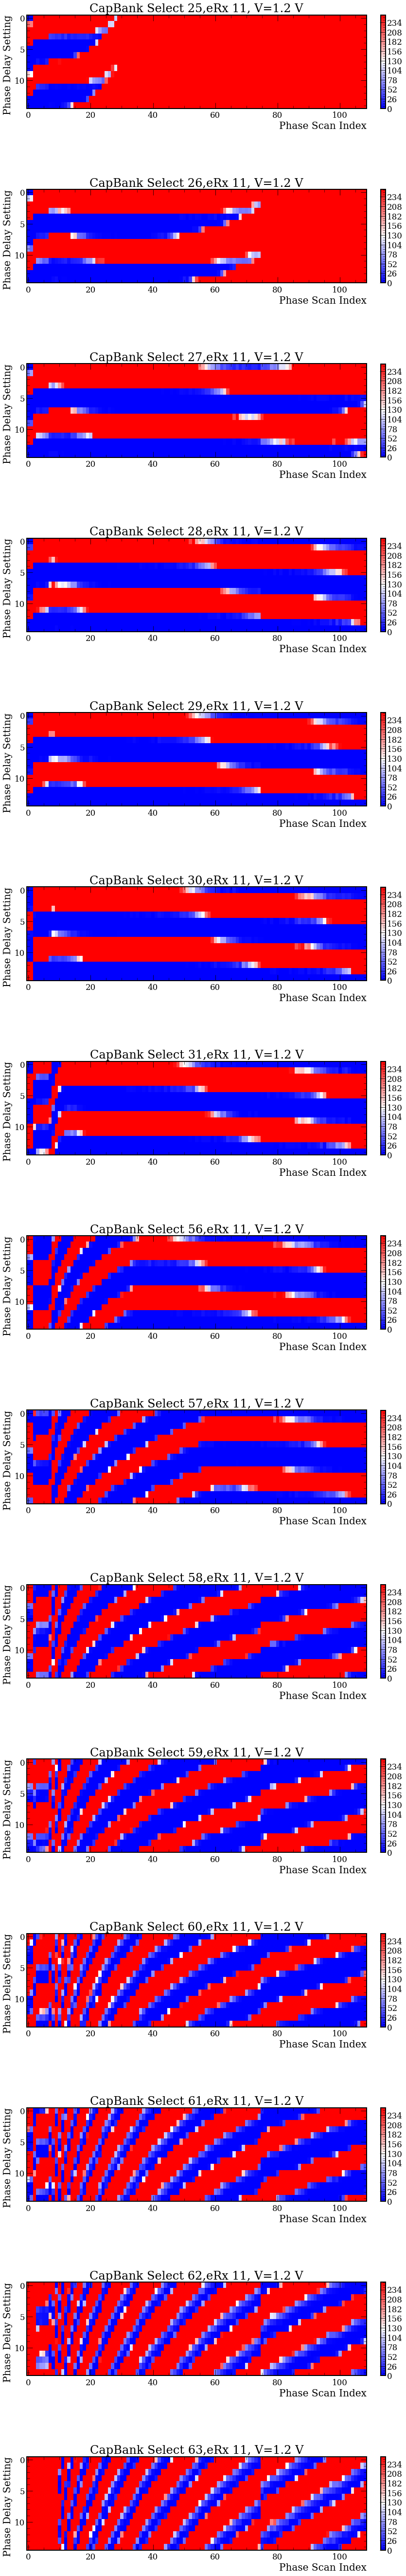

In [7]:
plot_phase_scans_tid('eRx','1_20',11,aspect=2)

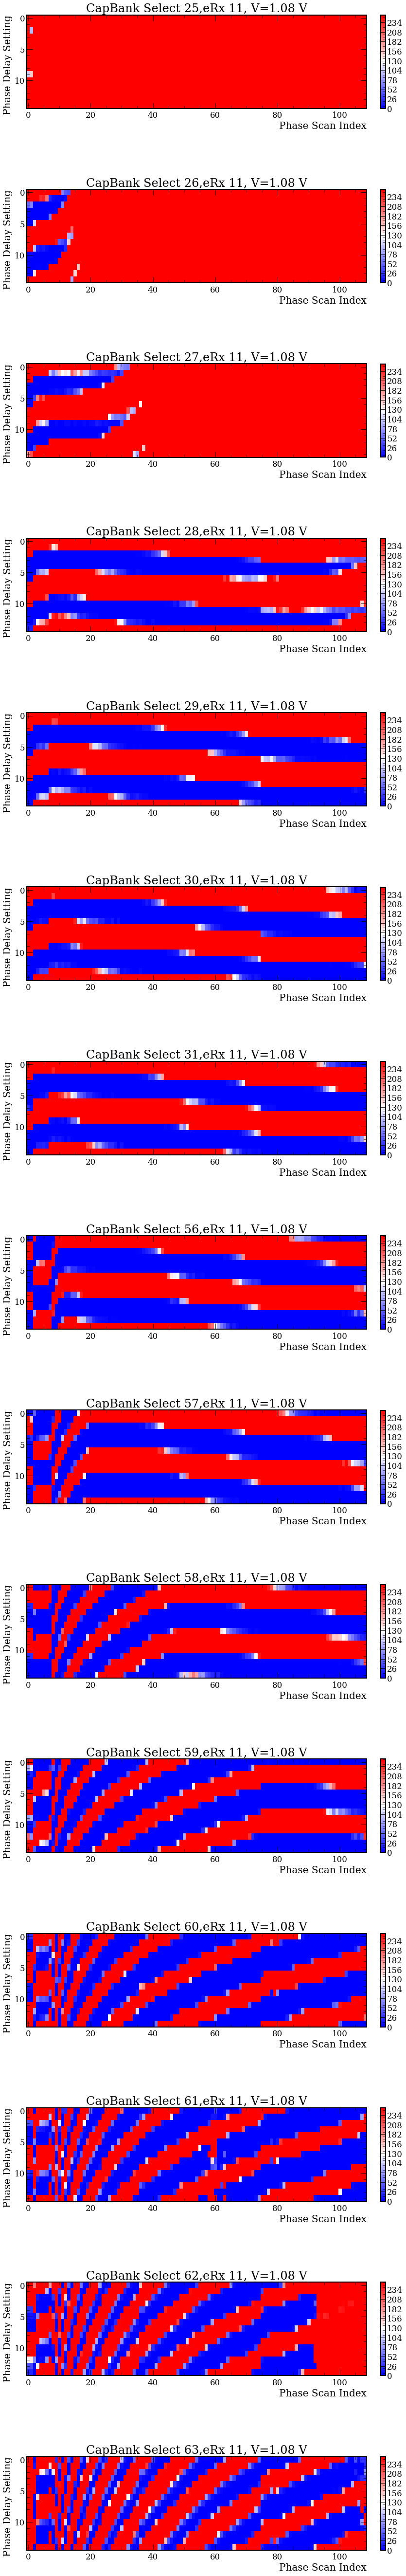

In [8]:
plot_phase_scans_tid('eRx','1_08',11,aspect=2)

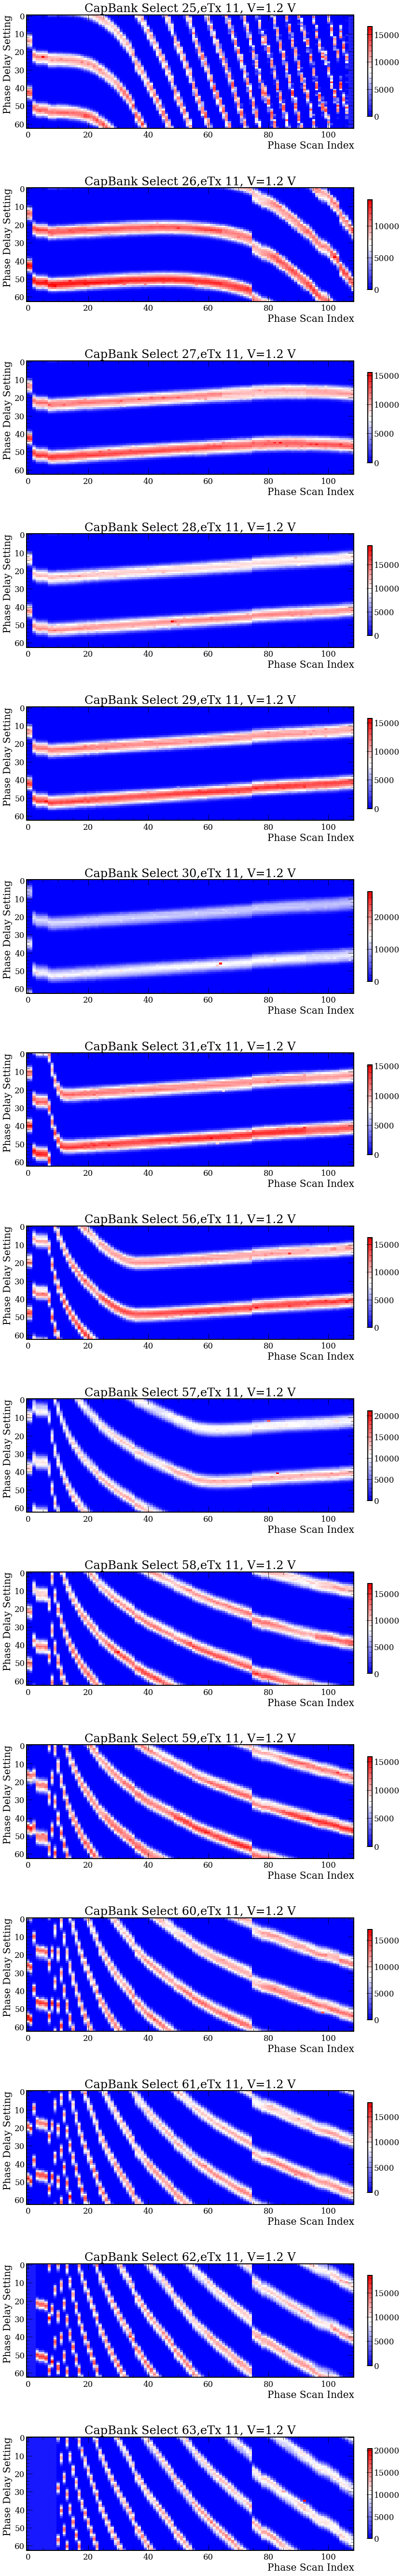

In [9]:
plot_phase_scans_tid('eTx','1_20',11,aspect=.6)

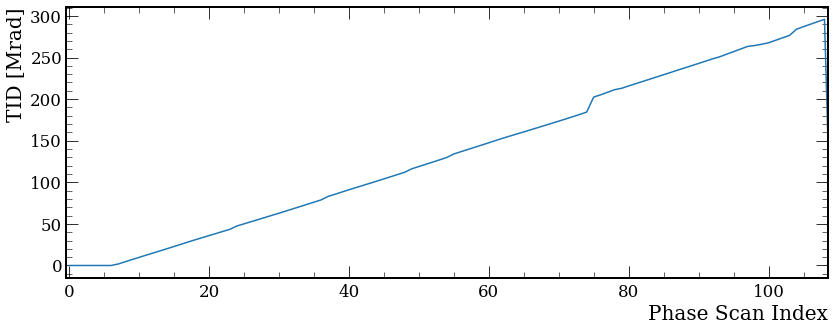

In [10]:
# Plot TID as a function of phase scan index
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax.plot(np.arange(len(df_scans)),df_scans.TID)
x=np.array(list(df_scans.loc[df_scans.capBank_val == 31][f'eRxScan_1_20'].values))
ax.set_xlim(-0.5,x.shape[0]-0.5);
ax.set_ylabel('TID [Mrad]')
ax.set_xlabel('Phase Scan Index')
fig.tight_layout()

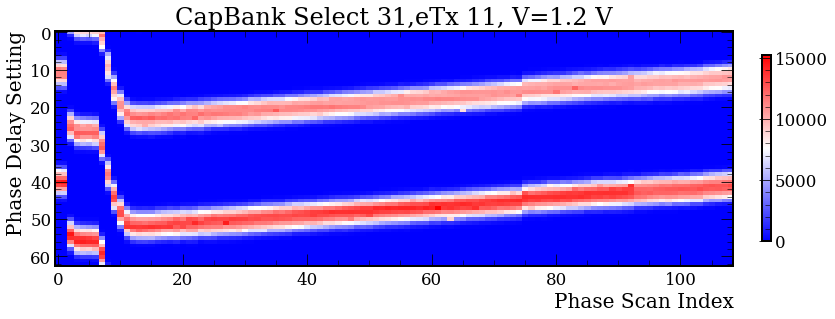

In [11]:
plot_phase_scans_tid('eTx','1_20',11,aspect=.6,pll_values=[31])

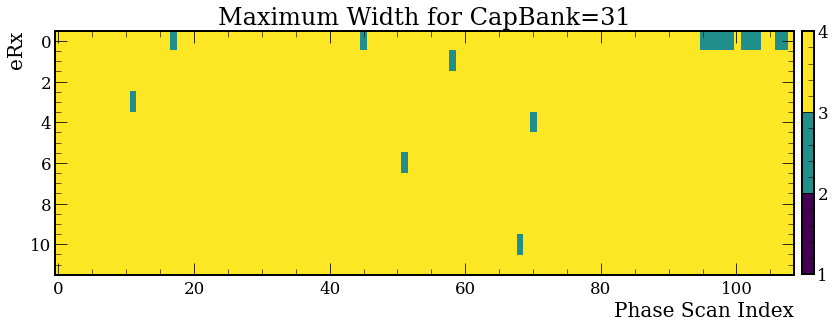

In [12]:
voltage = '1_20'
scan = 'eRx'
capBank = 31
x=np.array(list(df_scans.loc[df_scans.capBank_val == capBank][f'{scan}MaxWidth_{voltage}'].values))
#print(x[0])

fig,ax=plt.subplots(figsize=(12,9))
cmap = mpl.colormaps['viridis']
#bounds= [0,0.5,1,1.5,2,2.5,3,3.5,4]
bounds = [1,2,3,4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
im=plt.imshow(x.T,cmap=cmap,norm=norm)
fig.colorbar(im,fraction=0.016, pad=0.01,ax=ax)
ax.set_aspect(3)
ax.set_xlabel('Phase Scan Index')
ax.set_ylabel(f'{scan}')
ax.set_title(f'Maximum Width for CapBank={capBank}')
fig.tight_layout()